# <a id='toc1_'></a>[Data generation: Windpower](#toc0_)

This notebook describes the generation of windpower data, involving `CDS` data and the `Feedinlib`.

This notebook builds on top of the notebook presented in [this repository](https://github.com/PeijieZ/WindpowerlibTurbine-model).

**Table of contents**<a id='toc0_'></a>    
- [Data generation: Windpower](#toc1_)    
	- [CDS](#toc1_1_1_)
	- [Feedinlib](#toc1_1_2_)
- [Download data](#toc1_2_)    
- [Convert raw data to windspeed data](#toc1_3_)    
- [Generate Windpower data](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[CDS](#toc0_)
This tool derives windpower-data from actual weather data from the [Climate Data Store](https://cds.climate.copernicus.eu) provided by [Copernicus](https://copernicus.eu).

To download data from the CDS, one must 
1. [register](https://cds.climate.copernicus.eu/user/register) and create an account, and
2. [install the API](https://cds.climate.copernicus.eu/api-how-to).

### <a id='toc1_1_2_'></a>[Feedinlib](#toc0_)
Processing of the CDS data is done using [feedinlib](https://github.com/oemof/feedinlib).
To be able to process CDS's ED5-format data, an unreleased version of the software must be installed.

The command for this is as follows: `$> pip install https://github.com/oemof/feedinlib/archive/master.zip`

In [1]:
from feedinlib import era5

## <a id='toc1_2_'></a>[Download data](#toc0_)
The first step is to download wind data for a particular time and place.
Copernicus provides data for locations within the EU.

In [2]:
import pandas as pd

In [3]:
# Location: European Parliament in Brussels, Belgium
longitude, latitude = 4.375, 50.839

# Time span
start_date, end_date = '2020-07-01', '2020-07-31'

# Wind data requested for download
variable = "windpowerlib"

In [4]:
def request_CDS_data(target_file: str) -> None:
    """
    Request CDS data.
    :param target_file: file to store data in.
    """
    era5.get_era5_data_from_datespan_and_position(
        variable=variable,
        start_date=start_date,
        end_date=end_date,
        latitude=latitude,
        longitude=longitude,
        target_file=target_file
    )

# Request data
target_file = 'src/ERA5_wind_data_july_2020.nc'

# Uncomment the below line if you do wish to request the data (again). Note that this is an expensive API request
# request_CDS_data(target_file)

## <a id='toc1_3_'></a>[Convert raw data to windspeed data](#toc0_)

In [5]:
# Load weather data from target_file.
import xarray as xr
raw_data = xr.open_dataset(target_file, chunks=None)

# show the raw data
raw_data

<xarray.Dataset> Size: 27kB
Dimensions:    (longitude: 1, latitude: 1, time: 744)
Coordinates:
  * longitude  (longitude) float32 4B 4.5
  * latitude   (latitude) float32 4B 50.75
  * time       (time) datetime64[ns] 6kB 2020-07-01 ... 2020-07-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 3kB ...
    v100       (time, latitude, longitude) float32 3kB ...
    u10        (time, latitude, longitude) float32 3kB ...
    v10        (time, latitude, longitude) float32 3kB ...
    t2m        (time, latitude, longitude) float32 3kB ...
    fsr        (time, latitude, longitude) float32 3kB ...
    sp         (time, latitude, longitude) float32 3kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-27 21:41:08 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
# Convert to windpower data
data = era5.format_windpowerlib(raw_data)

# Remove location from index
new_idx = data.index.droplevel(['latitude', 'longitude'])
data = data.set_index(new_idx)

data

variable                  wind_speed                 pressure temperature  \
height                           10        100            0           2     
time                                                                        
2020-06-30 23:00:00+00:00   4.647963  8.296551   99895.250000  291.370300   
2020-07-01 00:00:00+00:00   4.783858  8.411263   99834.140625  291.038757   
2020-07-01 01:00:00+00:00   4.742291  8.279199   99805.132812  290.606781   
2020-07-01 02:00:00+00:00   4.561267  8.051223   99780.921875  290.483459   
2020-07-01 03:00:00+00:00   4.505437  7.918155   99752.453125  290.495544   
...                              ...       ...            ...         ...   
2020-07-31 18:00:00+00:00   2.386088  5.618336  100254.445312  302.563690   
2020-07-31 19:00:00+00:00   2.538475  5.794602  100242.890625  300.496857   
2020-07-31 20:00:00+00:00   2.628344  5.780726  100242.554688  299.836823   
2020-07-31 21:00:00+00:00   2.631720  6.051558  100283.250000  299.324615   
2020-07-31 22:00:00+00:00   3.385602  7.678968  100328.445312  298.135132   

variable                  roughness_length  
height                                 0    
time                                        
2020-06-30 23:00:00+00:00         0.362707  
2020-07-01 00:00:00+00:00         0.362807  
2020-07-01 01:00:00+00:00         0.362807  
2020-07-01 02:00:00+00:00         0.362806  
2020-07-01 03:00:00+00:00         0.362806  
...                                    ...  
2020-07-31 18:00:00+00:00         0.353747  
2020-07-31 19:00:00+00:00         0.353747  
2020-07-31 20:00:00+00:00         0.353747  
2020-07-31 21:00:00+00:00         0.353747  
2020-07-31 22:00:00+00:00         0.353748  

[744 rows x 5 columns]

Text(0, 0.5, 'Wind speed (m/s)')

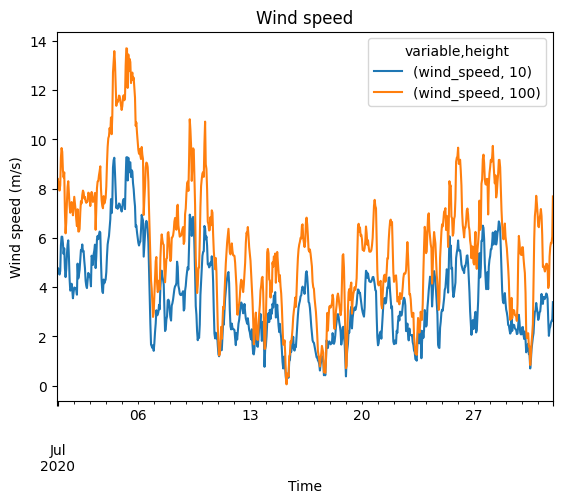

In [7]:
# Plot wind speed
import matplotlib.pyplot as plt


# Generate plot
data.loc[:, ['wind_speed']].plot(title='Wind speed')
plt.xlabel('Time')
plt.ylabel('Wind speed (m/s)')

## <a id='toc1_4_'></a>[Generate Windpower data](#toc0_)

You can use the windpower plant from the database, or create your own plant for modeling.

In [8]:
from feedinlib import WindPowerPlant

In [9]:
# Define three wind turbines with 1.0, 1.5, and 2.0 kW generation capacity.
turbine_properties = [
    {
    'nominal_power': 1000,  # in W
    'hub_height': 15,  # in m
    'power_curve': pd.DataFrame(
        data={
            'value': [0.0, 200.0, 450.0, 900.0, 1000.0, 850.0],  # in W
            'wind_speed': [0.0, 3.0, 6.0, 10.0, 12.0, 15.0]  # in m/s
            }
        )   
    },
    {
        'nominal_power': 1500,  # in W
        'hub_height': 15,  # in m
        'power_curve': pd.DataFrame(
            data={
                'value': [0.0, 300.0, 675.0, 1350.0, 1500.0, 1275.0],  # in W
                'wind_speed': [0.0, 3.0, 6.0, 10.0, 12.0, 15.0]  # in m/s
                }
            )
    },
    {
        'nominal_power': 2000,  # in W
        'hub_height': 15,  # in m
        'power_curve': pd.DataFrame(
            data={
                'value': [0.0, 400.0, 900.0, 1800.0, 2000.0, 1700.0],  # in W
                'wind_speed': [0.0, 3.0, 6.0, 10.0, 12.0, 15.0]  # in m/s
                }
            )
    },
]

my_turbines = [
    WindPowerPlant(**properties)
    for properties in turbine_properties
]

In [10]:
# Note: one can use feedinlib to get data on actual, large scale windturbines
# The information on these can also be used to create WindPowerPlant objects.
from feedinlib import get_power_plant_data
turbine_df = get_power_plant_data(dataset='oedb_turbine_library')
turbine_df

/home/erik/Documents/billing/.venv/lib/python3.10/site-packages/windpowerlib/data.py:103: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(False)


,manufacturer,turbine_type,has_power_curve,has_cp_curve
0,Adwen/Areva,AD116/5000,True,False
1,Enercon,E-101/3050,True,True
2,Enercon,E-101/3500,True,True
3,Enercon,E-115/3000,True,True
4,Enercon,E-115/3200,True,True
...,...,...,...,...
62,Vestas,V80/2000,True,False
63,Vestas,V90/2000,True,True
64,Vestas,V90/2000/GS,True,True
65,Vestas,V90/3000,True,False


In [11]:
performances = [
    turbine.feedin(weather=data, name=idx)
    for idx, turbine in enumerate(my_turbines)
]

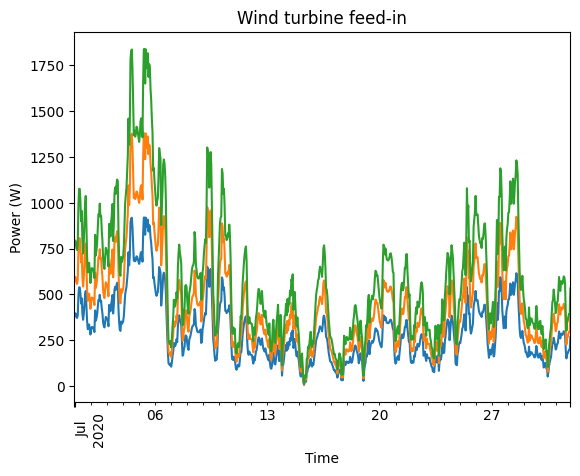

In [12]:
# plot calculated feed-in
for performance in performances:

    # Generate plot
    performance.plot(title='Wind turbine feed-in')
    plt.xlabel('Time')
    plt.xticks(rotation=90)
    plt.ylabel('Power (W)')

In [13]:
# Convert to pandas dataframe
df = pd.DataFrame(performances).T

# Rename headers
df = df.set_axis(['1kW', '1.5kW', '2kW'], axis=1)

df

,1kW,1.5kW,2kW
time,,,
2020-06-30 23:00:00+00:00,384.680502,577.020752,769.361003
2020-07-01 00:00:00+00:00,397.393576,596.090364,794.787153
2020-07-01 01:00:00+00:00,393.506201,590.259302,787.012402
2020-07-01 02:00:00+00:00,376.576575,564.864862,753.153149
2020-07-01 03:00:00+00:00,371.355247,557.032871,742.710495
...,...,...,...
2020-07-31 18:00:00+00:00,178.373241,267.559862,356.746483
2020-07-31 19:00:00+00:00,189.765056,284.647584,379.530112
2020-07-31 20:00:00+00:00,196.483262,294.724894,392.966525


## Extrapolate data

Next, we generate windpower data for multiple windmills by means of randomized sampling from the existing dataset.

In [14]:
# Generation settings
NR_WINDMILLS = 10
WT_EFFICIENCY_BOUNDS = 0.9, 1.1
DECIMAL_PRECISION = 4

In [15]:
from typing import List, Callable
import random

Vector = List[float]

def generate_vector(
        input_vectors: List[Vector], 
        randomizer: Callable[[float], float]
    ) -> Vector:
    """
    Generate random vector, using uniform sampling.
    :param input_data: set of vectors to sample from
    :param randomizer: callback used to compute a new value.
    :returns: uniformly random sampled vector
    """
    # 1. Select random existing data vector
    base_vector = random.choice(input_vectors)

    # 2. Generate random vector using uniformly random sampling
    new_vec = []
    for val in base_vector:
        new_val = randomizer(val)
        rounded_new_val = round(new_val, DECIMAL_PRECISION)
        new_vec.append(rounded_new_val)
    
    return new_vec

In [16]:
def randomizer(val: float) -> float:
    return (val * random.uniform(*WT_EFFICIENCY_BOUNDS)) / 1000

nr_new_performances = NR_WINDMILLS - len(performances)
for idx in range(nr_new_performances):
    # Generate new performance
    new_performance = generate_vector(performances, randomizer)

    # Add new performance to dataframe
    perf_series = pd.Series(new_performance, index=df.index)
    df.insert(3, idx, perf_series)

df

,1kW,1.5kW,2kW,6,5,4,3,2,1,0
time,,,,,,,,,,
2020-06-30 23:00:00+00:00,384.680502,577.020752,769.361003,0.8255,0.8074,0.5799,0.3765,0.5214,0.5897,0.3920
2020-07-01 00:00:00+00:00,397.393576,596.090364,794.787153,0.7816,0.7615,0.6276,0.4148,0.6438,0.5407,0.3818
2020-07-01 01:00:00+00:00,393.506201,590.259302,787.012402,0.8570,0.7309,0.5528,0.3899,0.6108,0.5646,0.4029
2020-07-01 02:00:00+00:00,376.576575,564.864862,753.153149,0.7129,0.7004,0.5285,0.3950,0.5620,0.5262,0.3573
2020-07-01 03:00:00+00:00,371.355247,557.032871,742.710495,0.6764,0.7539,0.5489,0.3455,0.5860,0.5713,0.3908
...,...,...,...,...,...,...,...,...,...,...
2020-07-31 18:00:00+00:00,178.373241,267.559862,356.746483,0.3331,0.3411,0.2606,0.1681,0.2916,0.2519,0.1861
2020-07-31 19:00:00+00:00,189.765056,284.647584,379.530112,0.3958,0.4087,0.2945,0.2074,0.2895,0.2653,0.1774
2020-07-31 20:00:00+00:00,196.483262,294.724894,392.966525,0.3559,0.3883,0.2787,0.1978,0.2666,0.2660,0.2137


## Export

In [22]:
def export_data(nr_days: int):
    samples = nr_days * 24
    selection = df.iloc[:samples]
    selection.to_json(f'out/windpower_{nr_days}_days.json', indent=4)

export_data(31)